In [1]:
# Transformations for modeling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline


In [2]:
touse = pd.read_csv("gamedata.csv")

#touse.isnull().sum()


- We need to dropna in possession time, there are only 7 accounts of this but no explanation as to why a team would not have zerp possession time alongside stats. Then we will fill all other na values with 0 as we have determined that null values are equivalent to 0.

In [3]:
# touse['possessionTime'] = touse['possessionTime'].fillna('00:00')

touse = touse.dropna(subset=['possessionTime'])

cleaned = touse.fillna(0)

cleaned.isnull().sum()

Game Id                0
School                 0
Conference             0
HomeAway               0
Points                 0
completionAttempts     0
firstDowns             0
fourthDownEff          0
fumblesLost            0
fumblesRecovered       0
interceptionYards      0
interceptions          0
kickReturnYards        0
kickReturns            0
netPassingYards        0
passesDeflected        0
passesIntercepted      0
possessionTime         0
puntReturnYards        0
puntReturns            0
qbHurries              0
rushingAttempts        0
rushingYards           0
sacks                  0
tackles                0
tacklesForLoss         0
thirdDownEff           0
totalFumbles           0
totalYards             0
turnovers              0
yardsPerPass           0
yardsPerRushAttempt    0
totalPenalties         0
penaltyYards           0
dtype: int64

- We need to drop the 'Game Id' column

In [4]:
dropped = cleaned.drop(columns = ["Game Id"])

#dropped

dropped.isna().sum()

School                 0
Conference             0
HomeAway               0
Points                 0
completionAttempts     0
firstDowns             0
fourthDownEff          0
fumblesLost            0
fumblesRecovered       0
interceptionYards      0
interceptions          0
kickReturnYards        0
kickReturns            0
netPassingYards        0
passesDeflected        0
passesIntercepted      0
possessionTime         0
puntReturnYards        0
puntReturns            0
qbHurries              0
rushingAttempts        0
rushingYards           0
sacks                  0
tackles                0
tacklesForLoss         0
thirdDownEff           0
totalFumbles           0
totalYards             0
turnovers              0
yardsPerPass           0
yardsPerRushAttempt    0
totalPenalties         0
penaltyYards           0
dtype: int64

- Assign dataframe to new name

In [5]:
test = dropped

# print(test['possessionTime'].to_string())

- We need to create a function to get possession time into seconds from a string.

In [6]:
# change possession time to seconds

def get_seconds(time_str):
    w = np.array([time_str.split(':')])
    mm,ss = w[:,0],w[:,1]
    return int(mm) * 60 + int(ss)



- We need to apply function rowwise and save to new column

In [7]:
test['newposs'] = test.loc[:,'possessionTime'].apply(lambda row: get_seconds(str(row)))


#test[['possessionTime','newposs']]

- We need to drop old column for possessiontime and rename new one as same

In [8]:
changedtime = test.drop(columns = ["possessionTime"])

changedtime = changedtime.rename(columns={'newposs':'possessionTime'})

changedtime.isna().sum()

School                 0
Conference             0
HomeAway               0
Points                 0
completionAttempts     0
firstDowns             0
fourthDownEff          0
fumblesLost            0
fumblesRecovered       0
interceptionYards      0
interceptions          0
kickReturnYards        0
kickReturns            0
netPassingYards        0
passesDeflected        0
passesIntercepted      0
puntReturnYards        0
puntReturns            0
qbHurries              0
rushingAttempts        0
rushingYards           0
sacks                  0
tackles                0
tacklesForLoss         0
thirdDownEff           0
totalFumbles           0
totalYards             0
turnovers              0
yardsPerPass           0
yardsPerRushAttempt    0
totalPenalties         0
penaltyYards           0
possessionTime         0
dtype: int64

- We need to convert categorical variables into dummy variables to regress on. We cannot just use label enconder as the model will learn untrue relations in the categorical variables, such as order

- Next, we need to standardize our continous variables so that they are on the same scale but we need to remove dummies and target before

- Lastly, we need to put the dataframe back together with our dummmies and target

In [9]:
# label_encoder = LabelEncoder()

# changedtime[['Conference','HomeAway','School']] = changedtime[['Conference','HomeAway','School']].apply(LabelEncoder().fit_transform)

changedtime = pd.get_dummies(changedtime)

tostandardize = changedtime.iloc[:,1:30]

scaler = StandardScaler()

standed = scaler.fit_transform(tostandardize)

standeddf = pd.DataFrame(standed,columns = tostandardize.columns)

# standeddf[['Conference','HomeAway']] = changedtime[['Conference','HomeAway']]

#standeddf.head()

a = pd.DataFrame(changedtime.iloc[:,0]).reset_index()

b = pd.DataFrame(changedtime.iloc[:,31:]).reset_index()

# standeddf.iloc[:,:30]

standeddf = pd.concat([a,standeddf,b],axis=1).drop(columns=['index'])

standeddf.tail()



,Points,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionYards,interceptions,kickReturnYards,kickReturns,...,School_Washington State,School_West Virginia,School_Wisconsin,Conference_ACC,Conference_Big 12,Conference_Big Ten,Conference_Pac-12,Conference_SEC,HomeAway_away,HomeAway_home
4201,10,-1.918824,-1.242192,0.239562,-0.751671,0.269075,-0.508622,-0.847175,-0.701833,-0.663051,...,False,False,False,False,False,False,False,True,True,False
4202,27,-0.118444,-0.902542,-0.973561,0.520062,-0.666238,-0.508622,-0.847175,-0.726359,-0.663051,...,False,False,False,False,False,False,False,True,False,True
4203,45,0.979514,0.116406,-0.973561,-0.751671,-0.666238,-0.029117,0.241828,0.622619,-0.093328,...,False,False,False,False,False,False,False,True,False,True
4204,37,0.251276,-0.562893,1.452686,-0.751671,0.269075,1.601200,0.241828,-0.088661,-0.093328,...,False,False,False,False,False,False,False,True,True,False
4205,28,0.608024,-0.393068,0.239562,-0.751671,-0.666238,0.690140,-0.847175,-0.677306,-0.663051,...,False,False,False,False,False,False,False,True,False,True


In [49]:
#standeddf.dtypes

- We need to learn which variable is correlated most with the dependent target variable. This will give us a basis regression model that we can hope to improve. 

In [10]:
mat = standeddf.corr(method='pearson')


uppcor = mat.where(np.triu(np.ones(mat.shape), k=1).astype(bool))

uniq = uppcor.unstack().dropna()

sormat = uniq.sort_values(ascending =False)

sormat.shape

abs(mat['Points']).sort_values(ascending=False).nlargest(10)

Points                 1.000000
totalYards             0.805261
firstDowns             0.659476
yardsPerPass           0.615613
rushingYards           0.573853
thirdDownEff           0.535238
yardsPerRushAttempt    0.502340
completionAttempts     0.486753
netPassingYards        0.481616
rushingAttempts        0.313701
Name: Points, dtype: float64

- We need to check our variables for multicollinearity. We will do this by using the variance inflation factor

- Here we will just check and we see that there is indeed high multicollinearity

- We will deal with these two cells down

In [11]:
pd.set_option('display.max_rows',None)

takeouty = standeddf.iloc[:,1:30]

vifs = pd.Series(np.linalg.inv(takeouty.corr().to_numpy()).diagonal(),
                index=takeouty.columns,name="VIF")

abs(vifs).sort_values(ascending=False)

turnovers              6.357453e+14
totalYards             3.825362e+14
interceptions          3.628866e+14
fumblesLost            2.660953e+14
netPassingYards        2.430278e+14
rushingYards           2.062658e+14
firstDowns             5.556343e+00
penaltyYards           5.275377e+00
totalPenalties         5.248448e+00
rushingAttempts        4.600784e+00
yardsPerRushAttempt    4.185710e+00
kickReturns            3.931843e+00
kickReturnYards        3.773168e+00
yardsPerPass           3.062549e+00
completionAttempts     2.039292e+00
puntReturns            1.803568e+00
possessionTime         1.794876e+00
thirdDownEff           1.769024e+00
tacklesForLoss         1.750881e+00
totalFumbles           1.696876e+00
sacks                  1.691076e+00
puntReturnYards        1.642448e+00
passesIntercepted      1.584446e+00
interceptionYards      1.526289e+00
tackles                1.261175e+00
passesDeflected        1.138154e+00
qbHurries              1.108739e+00
fourthDownEff          1.081

- This is just validation of the vif using an intercept, the intercept has no impact on the vif scores

- The warning is fine, division was by extremely small number which creates the inf you see in the table

In [12]:
from patsy import dmatrices

yout = standeddf.iloc[:,1:30]

features = '+'.join(yout.columns)

y,X = dmatrices("Points ~" + features ,standeddf,return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif['features'] = X.columns
vif.sort_values(by='VIF',ascending=False)

/Users/michaelguel/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,features
4,inf,fumblesLost
24,inf,turnovers
7,inf,interceptions
17,1.996149e+06,rushingYards
23,1.157712e+06,totalYards
10,4.569901e+05,netPassingYards
2,5.556343e+00,firstDowns
28,5.273314e+00,penaltyYards
27,5.246508e+00,totalPenalties
16,4.579806e+00,rushingAttempts


- We are now going to iteratively remove high vif variables

- We will start with the greatest vif, remove and continue to the next highest vif

- This will continue until we reach a set of variables that all vif are < 2.5

In [18]:
col = ['turnovers','netPassingYards']

tryagain = takeouty[takeouty.columns[~takeouty.columns.isin(col)]]

vifs = pd.Series(np.linalg.inv(tryagain.corr().to_numpy()).diagonal(),
                index=tryagain.columns,name="VIF")

abs(vifs).sort_values(ascending=False)



totalYards             9.767179
rushingYards           9.617821
firstDowns             5.556343
penaltyYards           5.275377
totalPenalties         5.248448
rushingAttempts        4.600784
yardsPerRushAttempt    4.185710
kickReturns            3.931843
kickReturnYards        3.773168
yardsPerPass           3.062549
completionAttempts     2.039292
puntReturns            1.803568
possessionTime         1.794876
thirdDownEff           1.769024
tacklesForLoss         1.750881
totalFumbles           1.696876
sacks                  1.691076
puntReturnYards        1.642448
fumblesLost            1.587367
passesIntercepted      1.584446
interceptionYards      1.526289
tackles                1.261175
interceptions          1.145940
passesDeflected        1.138154
qbHurries              1.108739
fourthDownEff          1.081038
fumblesRecovered       1.061936
Name: VIF, dtype: float64

- We will use the remaining variables after vif to construct a new dataframe that has little multicollinearity

- Assign both revised dataframe and original to new names to be used in the models

In [19]:
vifx = pd.concat([tryagain,b],axis=1)

full = standeddf.iloc[:,1:]

y = pd.DataFrame(standeddf.iloc[:,0])

In [20]:
X = vifx

Y = y

start_state = 24

test_fraction = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = test_fraction,random_state=start_state)

In [21]:
basis = LinearRegression()

basismodel = basis.fit(X_train[['totalYards']],y_train)

print(basismodel.score(X_test[['totalYards']],y_test))

print(cross_val_score(basis,X[['totalYards']],Y,cv=5))

0.6251350832353408
[0.62401127 0.65513867 0.63729175 0.6399628  0.66778388]


In [22]:
estimator1 = LinearRegression()

model1 = estimator1.fit(X_train,y_train)

print(model1.score(X_test,y_test))

#print(cross_val_score(estimator1,X,Y,cv=5))

y_pred_test_model1 = model1.predict(X_test)

print(np.sqrt(mean_squared_error(y_test,y_pred_test_model1)))

print(r2_score(y_test,y_pred_test_model1))

0.7973932690375505
6.64712881878785
0.7973932690375505


In [23]:
estimator2 = DecisionTreeRegressor()

model2 = estimator2.fit(X_train,y_train)

print(model2.score(X_test,y_test))

print(cross_val_score(estimator2,X,Y,cv=5))

0.45830232338487564
[0.36938626 0.43823251 0.53913207 0.44504156 0.50250248]


In [24]:
estimator3 = RandomForestRegressor(n_estimators=100)

model3 = estimator3.fit(X_train,np.ravel(y_train))

print(model3.score(X_test,y_test))

#print(cross_val_score(estimator3,X,np.ravel(Y),cv=5))

0.7574619482971283


In [25]:
estimator4 = xgb.XGBRegressor(objective='reg:squarederror')

model4 = estimator4.fit(X_train,y_train)

print(model4.score(X_test,y_test))

#print(cross_val_score(estimator4,X,Y,cv=5))

0.7570895233145251


In [26]:
estimator5 = MLPRegressor()

model5 = estimator5.fit(X_train,np.ravel(y_train))

print(model5.score(X_test,np.ravel(y_test)))

#print(cross_val_score(estimator5,X,np.ravel(Y),cv=5))

0.7844327073398449


In [29]:
params = {"alpha":[0.01,0.02,0.05,0.1,0.3,0.5,1.0,1.2,1.4],"kernel":['linear','laplacian','rbf']}

estimator6 = GridSearchCV(KernelRidge(),cv=5,param_grid=params)

tempmodel = estimator6.fit(X_train,y_train)

model6 = tempmodel.best_estimator_

print(model6.score(X_test,y_test))



0.7972328494961041


In [30]:
estimator7 = SVR(kernel='linear',gamma='scale')

model7 = estimator7.fit(X_train,np.ravel(y_train))

print(model7.score(X_test,np.ravel(y_test)))

0.7789063109009836


In [28]:
estimator8 = make_pipeline(StandardScaler(),
                           SGDRegressor(max_iter=1000,tol=1e-3))
model8 = estimator8.fit(X_train,np.ravel(y_train))

print(model8.score(X_test,np.ravel(y_test)))

0.7920744413846215


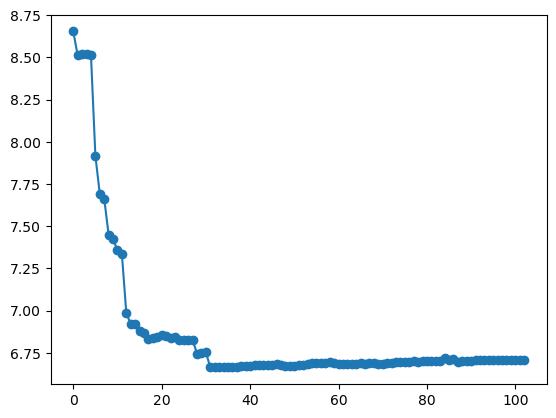

In [95]:
pca = PCA()

X_train_pc = pca.fit_transform(X_train)

#print(pca.explained_variance_ratio_)

rmse_list = []

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(estimator7,X_train_pc[:,:i],
                                     np.ravel(y_train),
                                     scoring = 'neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

plt.plot(rmse_list,'-o')

In [96]:
pcnum = 30

model6 = estimator7.fit(X_train_pc[:,:pcnum],np.ravel(y_train))

X_test_pc = pca.transform(X_test)[:,:pcnum]

print(model6.score(X_test_pc,np.ravel(y_test)))

#X_cross_pc = pca.transform(X)

#print(cross_val_score(estimator1,X_cross_pc,Y,cv=5))

0.7740222206549452
